In [1]:
ll /global/cscratch1/sd/dstn/dr9-cosmos-subs

total 40
drwxrwxr-x 9 dstn 4096 Feb 24 16:00 80/
drwxrwxr-x 9 dstn 4096 Feb 24 16:13 81/
drwxrwxr-x 9 dstn 4096 Feb 24 16:14 82/
drwxrwxr-x 9 dstn 4096 Feb 24 16:13 83/
drwxrwxr-x 9 dstn 4096 Feb 24 16:14 84/
drwxrwxr-x 9 dstn 4096 Feb 24 16:17 85/
drwxrwxr-x 9 dstn 4096 Feb 24 16:28 86/
drwxrwxr-x 9 dstn 4096 Feb 24 16:28 87/
drwxrwxr-x 9 dstn 4096 Feb 24 16:28 88/
drwxrwxr-x 9 dstn 4096 Feb 24 16:28 89/


In [2]:
ll /global/project/projectdirs/cosmo/work/legacysurvey/dr9.1.1/

total 8
drwxrwsr-x+  9 landriau 4096 Jun  1 10:07 calib/
drwxrws---+ 12 landriau 4096 Feb 19 17:54 coadd/
drwxrws---+ 12 landriau 4096 Feb 19 17:49 logs/
drwxrwsr-x+  3 landriau 4096 Dec 11 16:13 logs-calibs/
drwxrws---+ 12 landriau 4096 Feb 19 17:49 metrics/
drwxrws---+ 12 landriau 4096 Feb 19 17:57 tractor/
drwxrws---+ 12 landriau 4096 Feb 19 17:57 tractor-i/
drwxrwsr-x+  3 landriau 4096 Dec 11 16:14 zpts/


In [5]:
import os
import glob
import numpy as np
from matplotlib import pyplot as plt
from photometry import Catalogue, setup_logging, utils

output_dir = os.path.join(os.environ['CSCRATCH'],'legacysim','dr9','cosmos','merged')
deep_fn = os.path.join(output_dir,'deep.fits')
subs = range(80,90)
sub_fns = [os.path.join(output_dir,'sub_{:d}.fits'.format(isub)) for isub in subs]
dr9_fn = os.path.join(output_dir,'dr9.fits')
hsc_dir = '/global/cfs/cdirs/desi/target/analysis/truth/parent'
hsc_fn = os.path.join(hsc_dir,'hsc-pdr2-dud-cosmos-reduced.fits')
truth_fn = os.path.join(os.getenv('HOME'),'photometry','truth_cosmos_deep.fits')

bands = ['g','r','z','w1','w2']
keep = ['ra','dec','brick_primary','release','brickname','objid','maskbits']
keep += ['flux_{}'.format(b) for b in bands]
keep += ['fiberflux_{}'.format(b) for b in bands[:3]]
keep += ['type','sersic','shape_r','shape_e1','shape_e2']
keep += ['galdepth_{}'.format(b) for b in bands[:3]]
keep += ['mw_transmission_{}'.format(b) for b in bands]
keep += ['ebv']

def get_catalog(fn):
    catalog = Catalogue.load_fits(fn,keep=keep)
    return catalog[catalog['brick_primary']]

def match_catalogs(deep, hsc, distance_upper_bound=1./3600.):
    index_hsc = utils.match_ra_dec([deep['ra'],deep['dec']],radec2=[hsc['ra'],hsc['dec']],nn=1,distance_upper_bound=distance_upper_bound,degree=True)
    index_deep = np.arange(deep.size)
    mask = index_hsc < hsc.size
    index_hsc = index_hsc[mask]
    index_deep = index_deep[mask]
    print('Matching {:d} sources / {:d} (cosmos) and {:d} (hsc)'.format(index_hsc.size,deep.size,hsc.size))
    print('{:.3f} (cosmos) and {:.3f} (hsc)'.format(index_hsc.size/deep.size,index_hsc.size/hsc.size))
    catalog = deep.deepcopy()
    #catalog = deep[index_deep]
    for field in ['object_id']:
        catalog['hsc_{}'.format(field)] = - catalog.ones(dtype=hsc[field].dtype)
        catalog['hsc_{}'.format(field)][index_deep] = hsc[field][index_hsc]
    for field in ['ra','dec','demp_photoz_best','mizuki_photoz_best']:
        catalog['hsc_{}'.format(field)] = np.nan*catalog.ones(dtype=hsc[field].dtype)
        catalog['hsc_{}'.format(field)][index_deep] = hsc[field][index_hsc]
    return catalog

def fill_catalog(catalog):
    for b in bands[:3]:
        catalog['brick_galdepth_{}'.format(b)] = utils.digitized_statistics(catalog['brickname'],values=catalog['galdepth_{}'.format(b)],statistic='median')
        catalog['{}fiber'.format(b)] = utils.flux_to_mag(catalog['fiberflux_{}'.format(b)]/catalog['mw_transmission_{}'.format(b)])
    for b in bands:
        catalog[b] = utils.flux_to_mag(catalog['flux_{}'.format(b)]/catalog['mw_transmission_{}'.format(b)])
    catalog['shape_ba'],catalog['shape_phi'] = utils.get_shape_ba_phi(catalog['shape_e1'],catalog['shape_e2'])
    return catalog

def get_maskbit(catalog, bits=[1, 5, 6, 7, 11, 12, 13]):
    mask = catalog.trues()
    for bit in bits:
        mask &= (catalog['maskbits'] & 2**bit) == 0
    return mask

def get_mask_depth(catalog, threshold=(5000.,2000.,500.)):
    #return np.all([catalog['brick_galdepth_{}'.format(b)] > t for (b,t) in zip(bands,threshold)],axis=0)
    return np.all([catalog['galdepth_{}'.format(b)] > t for (b,t) in zip(bands,threshold)],axis=0)

from preprocess import isELG_colors
def get_mask_ts(catalog, priority='all', **kwargs):
    mask_low, mask_high = isELG_colors(**{'%sflux' % b:utils.mag_to_flux(catalog[b]) for b in ['g','r','z','gfiber']},**kwargs)
    if priority == 'low': return mask_low
    if priority == 'high': return mask_high
    return (mask_low | mask_high)

In [52]:
hsc = Catalogue.load_fits(hsc_fn)
print(hsc.fields)
truth = Catalogue.load_fits(truth_fn)

['object_id', 'ra', 'dec', 'g_psfflux_flux', 'r_psfflux_flux', 'i_psfflux_flux', 'z_psfflux_flux', 'y_psfflux_flux', 'g_psfflux_fluxsigma', 'r_psfflux_fluxsigma', 'i_psfflux_fluxsigma', 'z_psfflux_fluxsigma', 'y_psfflux_fluxsigma', 'g_cmodel_flux', 'r_cmodel_flux', 'i_cmodel_flux', 'z_cmodel_flux', 'y_cmodel_flux', 'g_cmodel_fluxsigma', 'r_cmodel_fluxsigma', 'i_cmodel_fluxsigma', 'z_cmodel_fluxsigma', 'y_cmodel_fluxsigma', 'g_cmodel_fracdev', 'r_cmodel_fracdev', 'z_cmodel_fracdev', 'g_extendedness_value', 'r_extendedness_value', 'i_extendedness_value', 'z_extendedness_value', 'g_extendedness_flag', 'r_extendedness_flag', 'i_extendedness_flag', 'z_extendedness_flag', 'g_sdsscentroid_flag', 'r_sdsscentroid_flag', 'i_sdsscentroid_flag', 'z_sdsscentroid_flag', 'y_sdsscentroid_flag', 'g_pixelflags_edge', 'r_pixelflags_edge', 'i_pixelflags_edge', 'z_pixelflags_edge', 'y_pixelflags_edge', 'g_pixelflags_interpolatedcenter', 'r_pixelflags_interpolatedcenter', 'i_pixelflags_interpolatedcenter', 

Text(0, 0.5, 'dec')

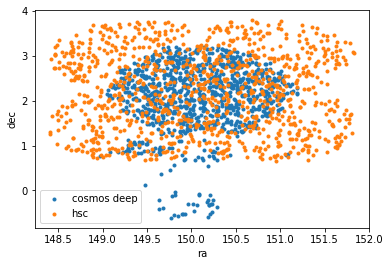

In [64]:
mask_truth = np.all([np.isfinite(truth[band]) for band in pbands],axis=0) & get_mask_depth(truth) #& get_maskbit(truth) & get_mask_ts(truth,gmarg=0.5,grmarg=0.5,rzmarg=0.5)
#mask_truth = truth.trues()
index = np.random.choice(mask_truth.sum(),replace=False,size=1000)
plt.scatter(truth['ra'][mask_truth][index],truth['dec'][mask_truth][index],marker='.',label='cosmos deep')
index = np.random.choice(hsc.size,replace=False,size=1000)
plt.scatter(hsc['ra'][index],hsc['dec'][index],marker='.',label='hsc')
plt.legend()
plt.xlabel('ra')
plt.ylabel('dec')

Text(0, 0.5, 'dec')

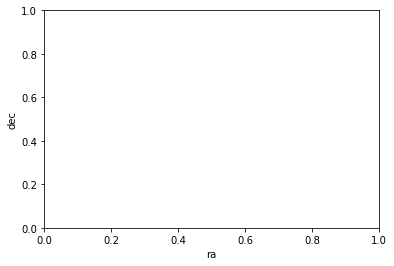

In [10]:
#plt.scatter(deep['ra'],deep['dec'],marker='.',label='cosmos deep')
basenames = ['hsc-pdr2-dud-cosmos-reduced.fits','hsc-pdr2-dud-deep2_3-reduced.fits','hsc-pdr2-dud-elais_n1-reduced.fits']
basenames += ['hsc-pdr2-dud-sxds_xmm_lss-reduced.fits','hsc_pdr1_deep.forced.reduced.fits','hsc_pdr1_udeep.forced.reduced.fits','hsc_pdr1_wide.forced.reduced.fits']
for i in range(1,8): basenames.append('hsc-pdr2-wide-w0{:d}-reduced.fits'.format(i))
# 4 5 9
i = 14
for basename in basenames[i:i+1]:
    hsc_fn_ = os.path.join(hsc_dir,basename)
    hsc_ = Catalogue.load_fits(hsc_fn_)
    plt.scatter(hsc_['ra'],hsc_['dec'],marker='.',label='hsc')
plt.xlabel('ra')
plt.ylabel('dec')

deep g 0.9742702928822393
hsc_match g 0.9927049032993341
deep r 0.9810926141051364
hsc_match r 0.9990630151026668
deep z 0.9618634424975893
hsc_match z 0.9984434577419812
std deep v.s. hsc_match 1.4604317 1.3338351
std deep v.s. hsc_match 1.4139205 1.3648335
std deep v.s. hsc_match 1.5814341 1.5581101


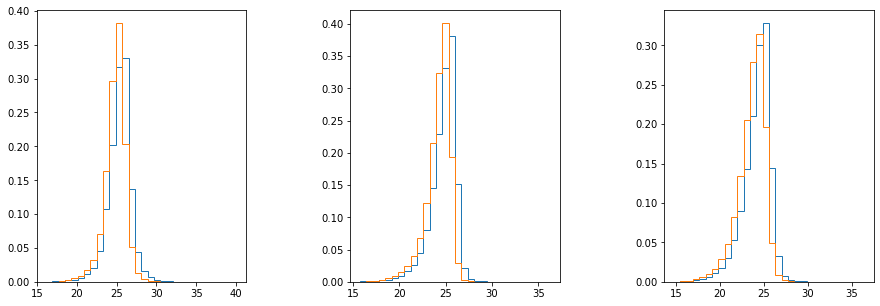

In [11]:
truth = Catalogue.load_fits(truth_fn)
mask_truth = get_mask_depth(truth) & get_maskbit(deep)
hsc_match = deep[mask_truth & (truth['hsc_object_id'] >= 0)]
mask_hsc_match = hsc_match.trues()
pbands = ['g','r','z']
for b in pbands:
    tmp = np.isfinite(deep[b])
    print('deep',b,tmp.sum()/tmp.size)
    mask_deep &= tmp
    tmp = np.isfinite(hsc_match[b])
    print('hsc_match',b,tmp.sum()/tmp.size)
    mask_hsc_match &= tmp
    
fig,lax = plt.subplots(ncols=len(pbands),nrows=1,sharex=False,sharey=False,figsize=(15,5),squeeze=False)
fig.subplots_adjust(hspace=0.4,wspace=0.5)
lax = lax.flatten()

for ax,band in zip(lax,pbands):
    bins = ax.hist(truth[band][mask_truth],histtype='step',label='all',density=True,bins=30)[1]
    ax.hist(hsc_match[band][mask_hsc_match],histtype='step',label='hsc_match',density=True,bins=bins)
    ax.set_xlabel(band)
    print('std deep v.s. hsc_match',np.std(truth[band][mask_truth]),np.std(hsc_match[band][mask_hsc_match]))
ax.legend()

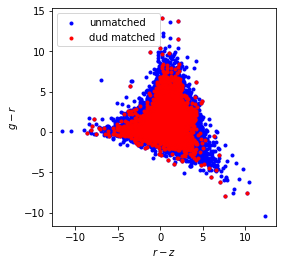

In [12]:
fig,ax = plt.subplots(ncols=1,nrows=1,sharex=False,sharey=False,figsize=(4,4))
ax.scatter(deep['r'][mask_deep] - deep['z'][mask_deep],deep['g'][mask_deep] - deep['r'][mask_deep],color='b',marker='.',label='unmatched')
ax.scatter(hsc_match['r'][mask_hsc_match] - hsc_match['z'][mask_hsc_match],hsc_match['g'][mask_hsc_match] - hsc_match['r'][mask_hsc_match],color='r',marker='.',label='dud matched')
ax.set_xlabel('$r-z$')
ax.set_ylabel('$g-r$')
ax.legend()

/global/homes/a/adematti/lib/photometry/utils/utils.py:21: RuntimeWarning: divide by zero encountered in log10
  return -2.5*(np.log10(x)-9.)
/global/homes/a/adematti/lib/photometry/utils/utils.py:21: RuntimeWarning: invalid value encountered in log10
  return -2.5*(np.log10(x)-9.)


Matching 1581759 sources / 6463929 (cosmos) and 2203724 (hsc)
0.245 (cosmos) and 0.718 (hsc)
Fraction of alls in geom region: 0.398
Fraction of selected sources in alls: 0.0078
Fraction of selected sources in hsc match at 1.0000 arcsec: 0.0130
Fraction of selected sources in alls (large box): 0.1035
Fraction of selected sources in hsc match  (large box) at 1.0000 arcsec: 0.1049
Dispersion of selected sources in alls (large box): [0.93527424, 1.0214919, 1.0272623]
Dispersion of selected sources in hsc_match (large box): [0.93517095, 1.0218703, 1.0266626]


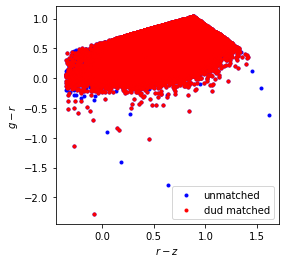

Matching 1603604 sources / 6463929 (cosmos) and 2203724 (hsc)
0.248 (cosmos) and 0.728 (hsc)
Fraction of alls in geom region: 0.398
Fraction of selected sources in alls: 0.0078
Fraction of selected sources in hsc match at 1.5000 arcsec: 0.0127
Fraction of selected sources in alls (large box): 0.1035
Fraction of selected sources in hsc match  (large box) at 1.5000 arcsec: 0.1048
Dispersion of selected sources in alls (large box): [0.93527424, 1.0214919, 1.0272623]
Dispersion of selected sources in hsc_match (large box): [0.9355607, 1.0220488, 1.0267977]


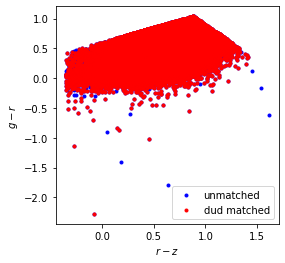

In [61]:
deep = Catalogue.load_fits(deep_fn)
hsc = Catalogue.load_fits(hsc_fn)
fill_catalog(deep)

for radius in [1.,1.5]:
    alls = match_catalogs(deep,hsc,distance_upper_bound=radius/3600.)
    mask_alls = get_mask_depth(alls) & get_maskbit(alls)
    mask_geom = (alls['ra'] > 148.) & (alls['ra'] < 152.) & (alls['dec'] > 1.) & (alls['dec'] < 4.)
    print('Fraction of alls in geom region: {:.3f}'.format(mask_geom.sum()*1./mask_geom.size))
    mask_alls &= mask_geom
    mask_hsc_match = mask_alls & (alls['hsc_object_id'] >= 0)
    mask_alls_ts = mask_alls & get_mask_ts(alls)
    mask_hsc_match_ts = mask_hsc_match & get_mask_ts(alls)
    print('Fraction of selected sources in alls: {:.4f}'.format(mask_alls_ts.sum()*1./mask_alls.sum()))
    print('Fraction of selected sources in hsc match at {:.4f} arcsec: {:.4f}'.format(radius,mask_hsc_match_ts.sum()*1./mask_hsc_match.sum()))
    mask_alls &= get_mask_ts(alls,gmarg=0.5,grmarg=0.5,rzmarg=0.5)
    mask_hsc_match &= get_mask_ts(alls,gmarg=0.5,grmarg=0.5,rzmarg=0.5)
    print('Fraction of selected sources in alls (large box): {:.4f}'.format(mask_alls_ts.sum()*1./mask_alls.sum()))
    print('Fraction of selected sources in hsc match  (large box) at {:.4f} arcsec: {:.4f}'.format(radius,mask_hsc_match_ts.sum()*1./mask_hsc_match.sum()))
    print('Dispersion of selected sources in alls (large box): {}'.format([np.std(alls[b][mask_alls]) for b in pbands]))
    print('Dispersion of selected sources in hsc_match (large box): {}'.format([np.std(alls[b][mask_hsc_match]) for b in pbands]))
    fig,ax = plt.subplots(ncols=1,nrows=1,sharex=False,sharey=False,figsize=(4,4))
    ax.scatter(alls['r'][mask_alls] - alls['z'][mask_alls],alls['g'][mask_alls] - alls['r'][mask_alls],color='b',marker='.',label='unmatched')
    ax.scatter(alls['r'][mask_hsc_match] - alls['z'][mask_hsc_match],alls['g'][mask_hsc_match] - alls['r'][mask_hsc_match],color='r',marker='.',label='dud matched')
    ax.set_xlabel('$r-z$')
    ax.set_ylabel('$g-r$')
    ax.legend()
    plt.show()

In [77]:
alls = match_catalogs(deep,hsc,distance_upper_bound=2.5/3600.)
mask_footprint = (alls['ra'] > 148.) & (alls['ra'] < 152.) & (alls['dec'] > 1.) & (alls['dec'] < 4.)
mask_all_ts = get_mask_depth(alls) & get_maskbit(alls) & get_mask_ts(alls,gmarg=0.5,grmarg=0.5,rzmarg=0.5) & mask_footprint
mask_all_ts &= get_mask_ts(alls,gmarg=0.,grmarg=0.,rzmarg=0.)
mask_hsc_unmatch = mask_all_ts & (alls['hsc_object_id'] < 0)
print('Fraction of sources in the enlarged selection box that are not matched with hsc: {}'.format(mask_hsc_unmatch.sum()*1./mask_all_ts.sum()))

Matching 1727746 sources / 6463929 (cosmos) and 2203724 (hsc)
0.267 (cosmos) and 0.784 (hsc)
Fraction of sources in the enlarged selection box that are not matched with hsc: 0.004153207198892478


kstest for g: KstestResult(statistic=0.29561264079030575, pvalue=0.01408026495638659)
kstest for r: KstestResult(statistic=0.1745543420670324, pvalue=0.34482048383746766)
kstest for z: KstestResult(statistic=0.13832060024953427, pvalue=0.6325758447827502)


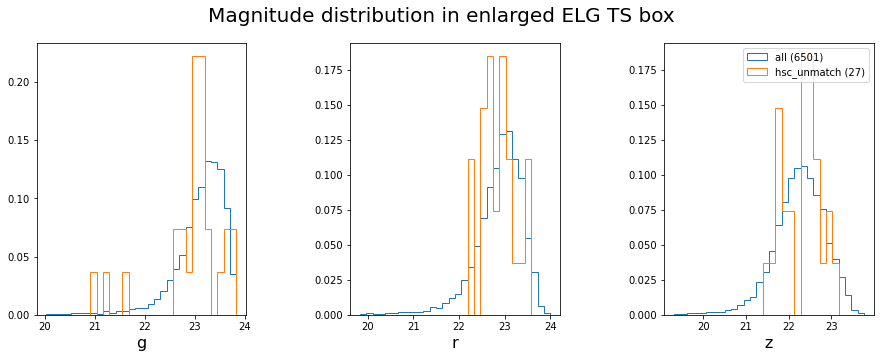

In [76]:
#alls = Catalogue.load_fits(truth_fn)
mask_footprint = (alls['ra'] > 148.) & (alls['ra'] < 152.) & (alls['dec'] > 1.) & (alls['dec'] < 4.)
mask_alls = np.all([np.isfinite(alls[band]) for band in pbands],axis=0) & get_mask_depth(alls) & get_maskbit(alls) & get_mask_ts(alls,gmarg=0.5,grmarg=0.5,rzmarg=0.5) & mask_footprint
mask_alls &= get_mask_ts(alls,gmarg=0.,grmarg=0.,rzmarg=0.)
mask_hsc_unmatch = mask_alls & (alls['hsc_object_id'] <= 0)

from scipy import stats

def get_weights(mask):
    return np.ones(mask.sum(),dtype='f8')/mask.sum()

fig,lax = plt.subplots(ncols=len(pbands),nrows=1,sharex=False,sharey=False,figsize=(15,5),squeeze=False)
fig.suptitle('Magnitude distribution in enlarged ELG TS box',fontsize=20)
fig.subplots_adjust(hspace=0.4,wspace=0.5)
lax = lax.flatten()

for ax,band in zip(lax,pbands):
    bins = ax.hist(alls[band][mask_alls],histtype='step',label='all ({:d})'.format(mask_alls.sum()),weights=get_weights(mask_alls),density=False,bins=30)[1]
    ax.hist(alls[band][mask_hsc_unmatch],histtype='step',label='hsc_unmatch ({:d})'.format(mask_hsc_unmatch.sum()),weights=get_weights(mask_hsc_unmatch),density=False,bins=bins)
    print('kstest for {}:'.format(band),stats.kstest(alls[band][mask_hsc_unmatch],alls[band][mask_alls]))
    ax.set_xlabel(band,fontsize=16)
ax.legend()

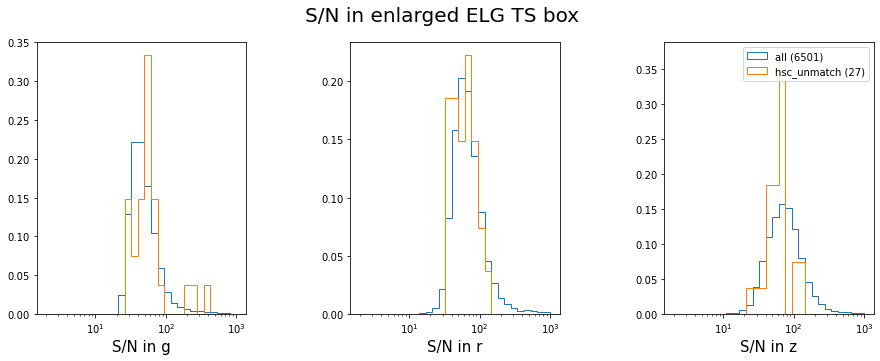

In [79]:
fig,lax = plt.subplots(ncols=len(pbands),nrows=1,sharex=False,sharey=False,figsize=(15,5),squeeze=False)
fig.suptitle('S/N in enlarged ELG TS box',fontsize=20)
fig.subplots_adjust(hspace=0.4,wspace=0.5)
lax = lax.flatten()

def get_sn(catalog, band):
    return catalog['flux_{}'.format(band)]*np.sqrt(catalog['galdepth_{}'.format(band)])

for ax,band in zip(lax,pbands):
    sn = get_sn(alls,band)
    bins = np.logspace(np.log10(2.),3,30)
    bins = ax.hist(sn[mask_alls],histtype='step',label='all ({:d})'.format(mask_alls.sum()),weights=get_weights(mask_alls),density=False,bins=bins)[1]
    ax.hist(sn[mask_hsc_unmatch],histtype='step',label='hsc_unmatch ({:d})'.format(mask_hsc_unmatch.sum()),weights=get_weights(mask_hsc_unmatch),density=False,bins=bins)
    ax.set_xlabel('S/N in {}'.format(band),fontsize=15)
    ax.set_xscale('log')
ax.legend()
#utils.savefig(os.path.join('plots','sn_hsc_cosmos_unmatched.png'))

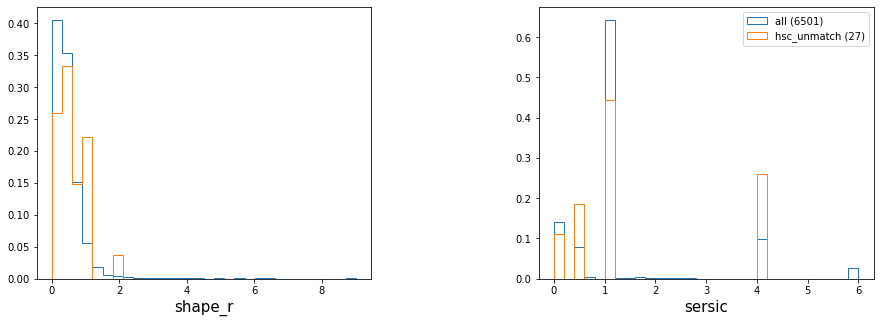

In [80]:
fields = ['shape_r','sersic']

fig,lax = plt.subplots(ncols=len(fields),nrows=1,sharex=False,sharey=False,figsize=(15,5),squeeze=False)
fig.subplots_adjust(hspace=0.4,wspace=0.5)
lax = lax.flatten()

for ax,field in zip(lax,fields):
    bins = ax.hist(alls[field][mask_alls],histtype='step',label='all ({:d})'.format(mask_alls.sum()),weights=get_weights(mask_alls),density=False,bins=30)[1]
    ax.hist(alls[field][mask_hsc_unmatch],histtype='step',label='hsc_unmatch ({:d})'.format(mask_hsc_unmatch.sum()),weights=get_weights(mask_hsc_unmatch),density=False,bins=bins)
    ax.set_xlabel(field,fontsize=15)
ax.legend()

Matched fraction 0.9341633408525652


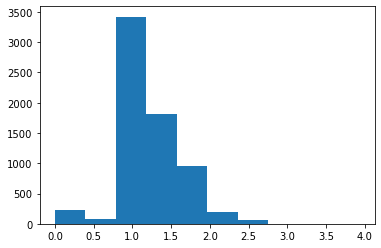

In [50]:
print('Matched fraction',(mask_alls & (alls['hsc_object_id'] >= 0)).sum()*1./mask_alls.sum())
mask_hsc_match = mask_alls & get_mask_ts(alls,gmarg=0.,grmarg=0.,rzmarg=0.) & (alls['hsc_object_id'] > 0)
plt.hist(alls['hsc_mizuki_photoz_best'][mask_hsc_match]);

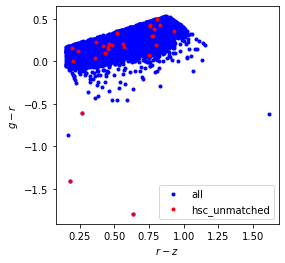

In [82]:
mask_footprint = (alls['ra'] > 148.) & (alls['ra'] < 152.) & (alls['dec'] > 1.) & (alls['dec'] < 4.)
mask_alls = np.all([np.isfinite(alls[band]) for band in pbands],axis=0) & get_mask_depth(alls) & get_maskbit(alls) & get_mask_ts(alls,gmarg=0.5,grmarg=0.5,rzmarg=0.5) & mask_footprint
mask_alls &= get_mask_ts(alls,gmarg=0.,grmarg=0.,rzmarg=0.)
mask_hsc_unmatch = mask_alls & (alls['hsc_object_id'] <= 0)

fig,ax = plt.subplots(ncols=1,nrows=1,sharex=False,sharey=False,figsize=(4,4))
ax.scatter(alls['r'][mask_alls] - alls['z'][mask_alls],alls['g'][mask_alls] - alls['r'][mask_alls],color='b',marker='.',label='all')
ax.scatter(alls['r'][mask_hsc_unmatch] - alls['z'][mask_hsc_unmatch],alls['g'][mask_hsc_unmatch] - alls['r'][mask_hsc_unmatch],color='r',marker='.',label='hsc_unmatched')
ax.set_xlabel('$r-z$')
ax.set_ylabel('$g-r$')
ax.legend()
plt.show()